# Step index guide approximating smooth refractive index profile

We should be able to do this just by sampling a function at some point in the interval comprising $R_j$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact, plot_complex
from scipy.optimize import newton
from scipy.integrate import quad
plt.style.use('dark_background')
%matplotlib widget

In [37]:
width_ri = 2
N = 10
dx = width_ri / N
T_left, T_right = 3, 3

Ts = [T_left] + [dx for i in range(N)] + [T_right]
ns = np.ones_like(Ts)

In [38]:
B = SlabExact(Ts=Ts, ns=ns, symmetric=True)

In [39]:
radius_ri = width_ri / 2
center_ri = 0
amp_ri = 1

left_ri, right_ri = center_ri - radius_ri, center_ri + radius_ri
n_outer = 1

def n_func(x):
    conds = [(x<left_ri), ((left_ri<=x)*(x<=right_ri)), (x>right_ri)]
    funcs = [0, lambda x: amp_ri * (1 - ((x - center_ri) / radius_ri)**2), 0]
    return np.piecewise(x, conds, funcs) + n_outer

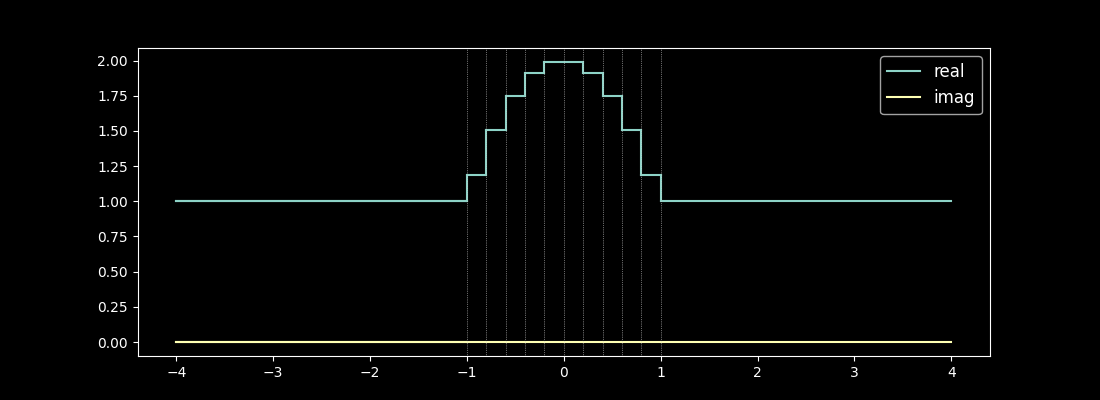

In [40]:
A = SlabExact(Ts=Ts, ns=n_func((B.Rhos[:-1] + B.Rhos[1:])/2), xrefs=B.xrefs+8, symmetric=True, wl=1e-6)
A.plot_refractive_index(Rho_linewidth=.5);

## Modes

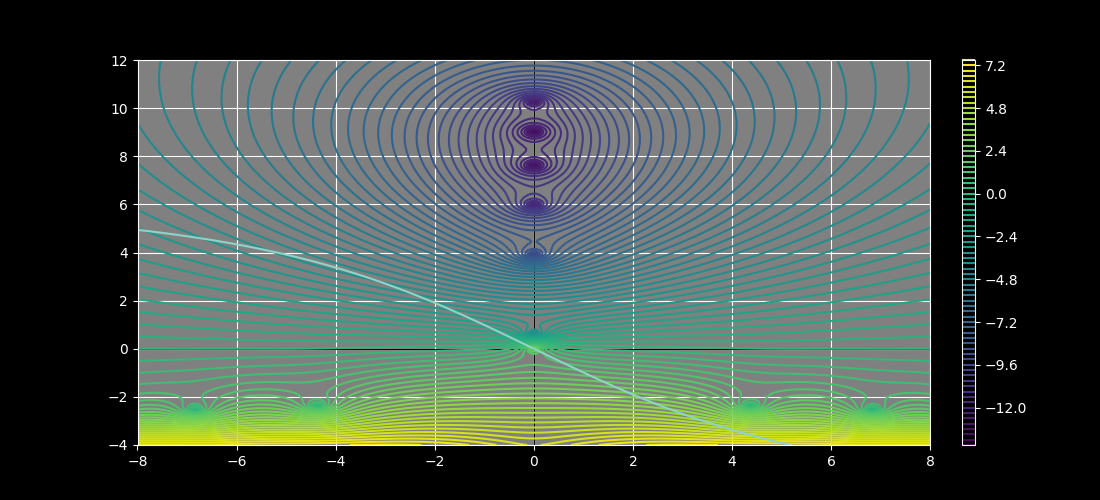

In [59]:
A.determinant_plot(-8, 8, -4, 12);

In [60]:
guided_guesses = [
    11j,
    9j,
    7.5j,
    6j,
    4j,
]

In [61]:
ft = 'TE'
args = ('Z', 'guided', ft)

Zs_guided = [newton(A.determinant, np.array(Z), args=args) for Z in guided_guesses]
Fs_guided = [A.fields(Z, field_type=ft) for Z in Zs_guided]

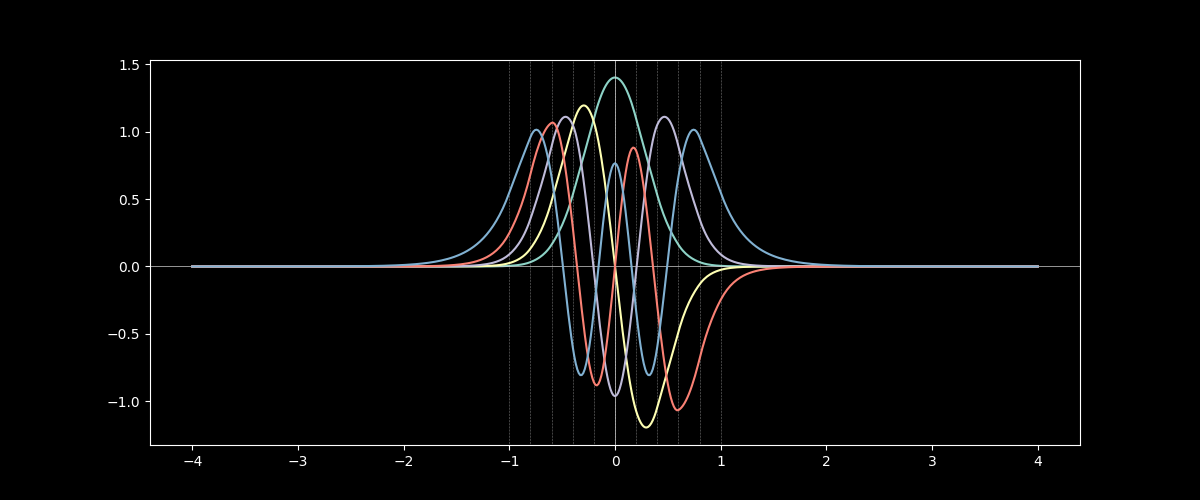

In [62]:
A.plot_field_1d(Fs_guided[0], Rho_linewidth=.4)
A.add_1d_plot(Fs_guided[1])
A.add_1d_plot(Fs_guided[2])
A.add_1d_plot(Fs_guided[3])
A.add_1d_plot(Fs_guided[4])

## Propagation

In [63]:
amp_input = 2.5
rad_input = .35
center_input = .15
left_input, right_input = center_input - rad_input, center_input + rad_input

def quadratic_piecewise(x):
    conds = [(x<left_input), ((left_input<=x)*(x<=right_input)), (x>right_input)]
    funcs = [0, lambda x: amp_input * (1 - ((x - center_input) / rad_input)**2), 0]
    return np.piecewise(x, conds, funcs)

f0 = quadratic_piecewise

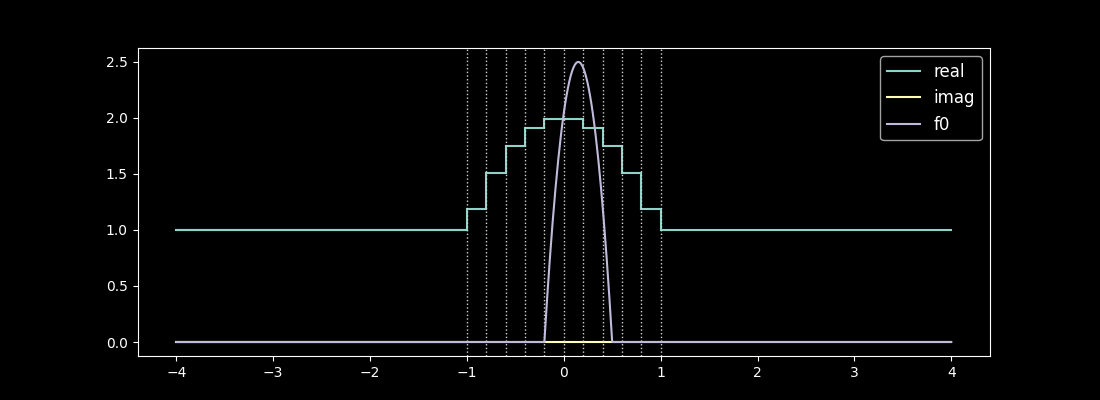

In [64]:
A.plot_refractive_index()
A.add_1d_plot(f0, label='f0', c='C2')

### Guided Portion

In [65]:
alphas_guided = [quad(lambda x: F(x) * f0(x), left_input, right_input, complex_func=True)[0] for F in Fs_guided]

In [66]:
z0 = 0
x0 = 0

guided_x = lambda x: sum([alpha * F(x, z0)[0] for alpha, F in zip(alphas_guided, Fs_guided)])
guided_z = lambda z: sum([alpha * F(x0, z) for alpha, F in zip(alphas_guided, Fs_guided)])
Guided = lambda x, z: sum([alpha * F(x, z) for alpha, F in zip(alphas_guided, Fs_guided)])

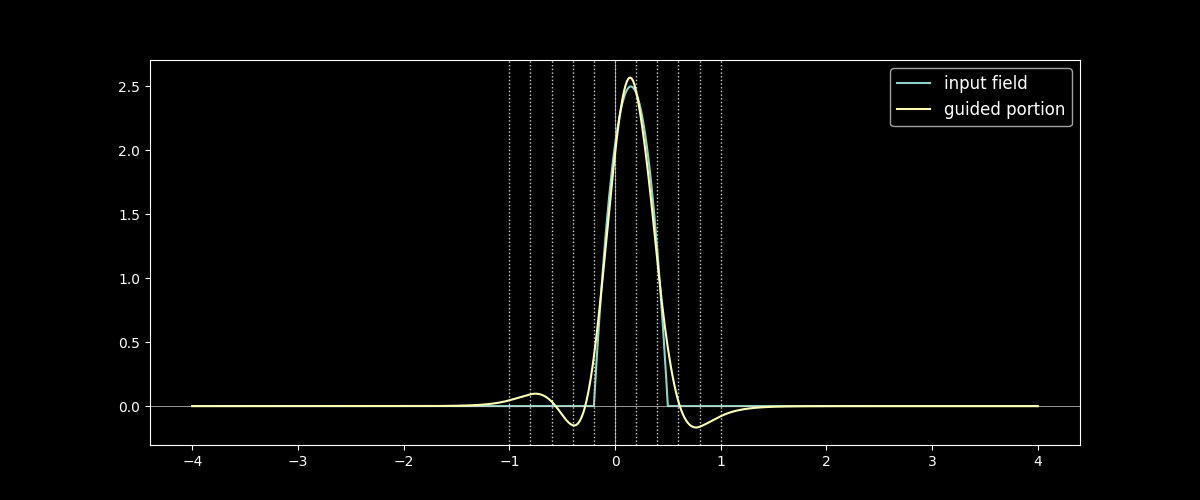

In [67]:
A.plot_field_1d(f0, label='input field')
A.add_1d_plot(guided_x, label='guided portion')

### Radiation Portion

In [47]:
Propagator_Class = A.propagator()
N = A.normalizer('eigvec')

In [104]:
P_prop1e = Propagator_Class(A.real_contour(0.000001, A.Z_evanescent, 200), f0=f0, Lx=left_input, Rx=right_input,
                            sign=1, Normalizer=N)
P_prop1o = Propagator_Class(A.real_contour(0.000001, A.Z_evanescent, 200), f0=f0, Lx=left_input, Rx=right_input,
                            sign=-1, Normalizer=N)

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

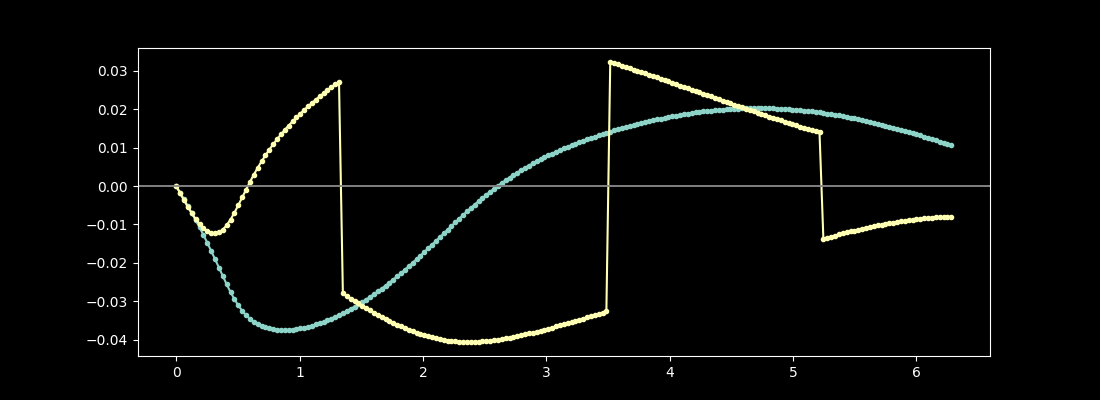

In [105]:
P_prop1e.plot_transform()
P_prop1o.plot_transform(ax=plt.gca())

In [106]:
P_ev1e = Propagator_Class(A.real_contour(A.Z_evanescent, 60, 300), f0=f0, Lx=left_input, Rx=right_input,
                          sign=1, Normalizer=N)
P_ev1o = Propagator_Class(A.real_contour(A.Z_evanescent, 60, 300), f0=f0, Lx=left_input, Rx=right_input,
                          sign=-1, Normalizer=N)

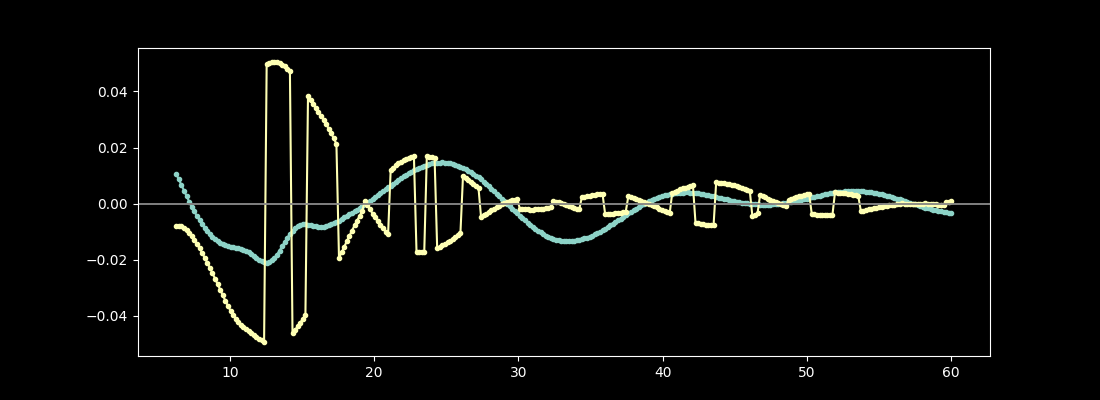

In [107]:
P_ev1e.plot_transform()
P_ev1o.plot_transform(ax=plt.gca());

In [108]:
propfuncs = [
    P_prop1e,
    P_prop1o,
    P_prop2e,
    P_prop2o,
]

evfuncs = [
    P_ev1e, 
    P_ev1o,
]

In [109]:
prop_x = lambda x: sum([f.slice_propagate(x) for f in propfuncs])
ev_x = lambda x: sum([f.slice_propagate(x) for f in evfuncs]) 
rad_x = lambda x: prop_x(x) + ev_x(x) 
full_x = lambda x: rad_x(x) + guided_x(x)

prop_z = lambda z: sum([f.slice_propagate(z, slice_at=x0, constant_variable='x') for f in propfuncs])
ev_z = lambda z: sum([f.slice_propagate(z, slice_at=x0, constant_variable='x') for f in evfuncs]) 
rad_z = lambda z: prop_z(z) + ev_z(z)
full_z = lambda z: rad_z(z) + guided_z(z)

Prop = lambda x, z: sum([f.propagate(x, z) for f in propfuncs])
Ev = lambda x, z: sum([f.propagate(x, z) for f in evfuncs]) 
Rad = lambda x, z: Prop(x, z) + Ev(x, z)
Full = lambda x, z: Rad(x, z) + Guided(x, z)

## Plots

### Input fields match

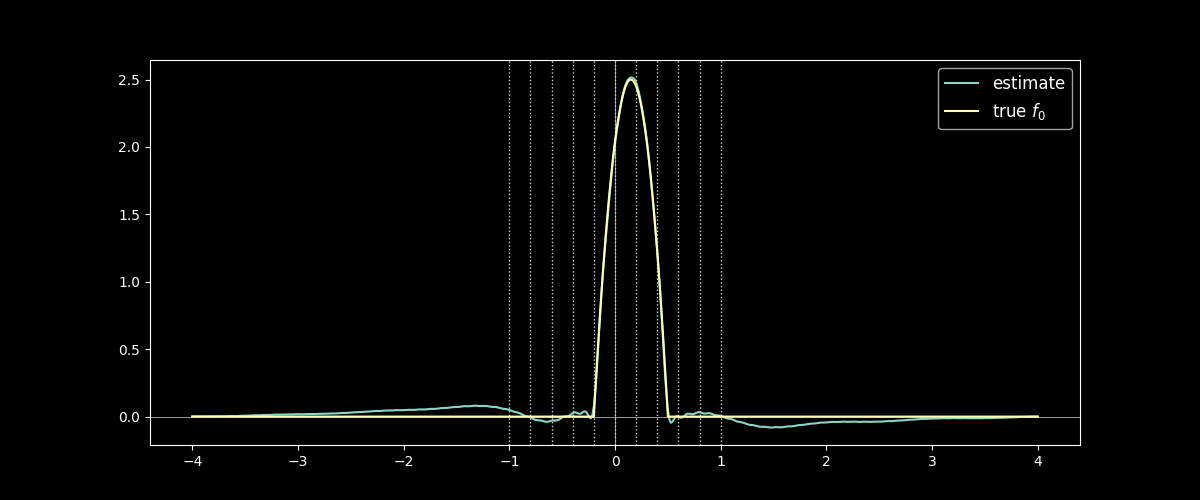

In [110]:
A.plot_field_1d(full_x, label='estimate') 
A.add_1d_plot(f0, label='true $f_0$')
# A.add_1d_plot(guided_x)

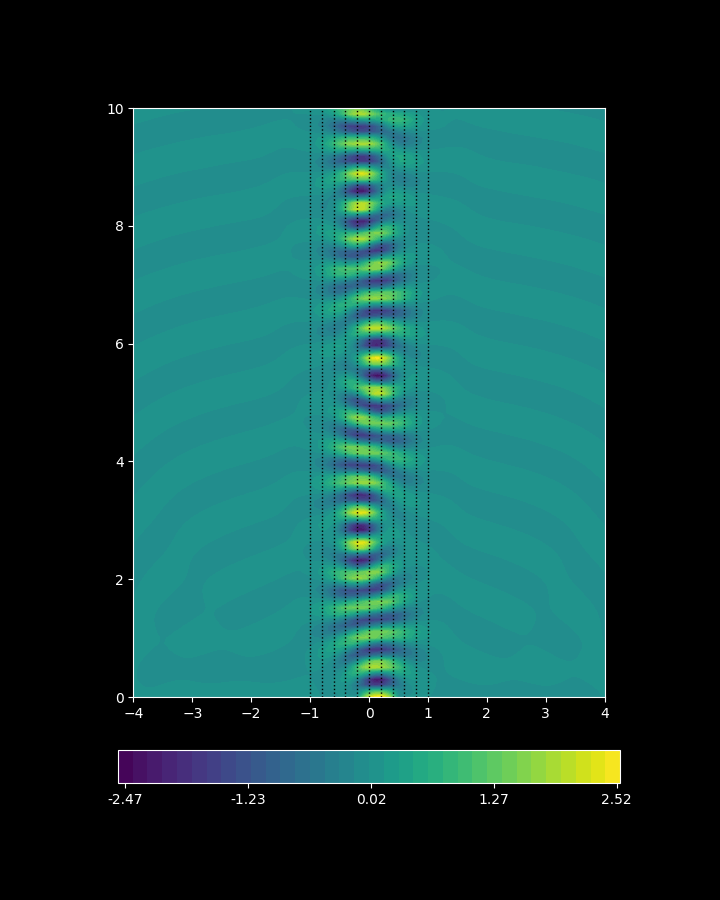

In [111]:
A.plot_field_2d(Full, zmax=10);

(<Figure size 1000x500 with 1 Axes>, <Axes3D: >)

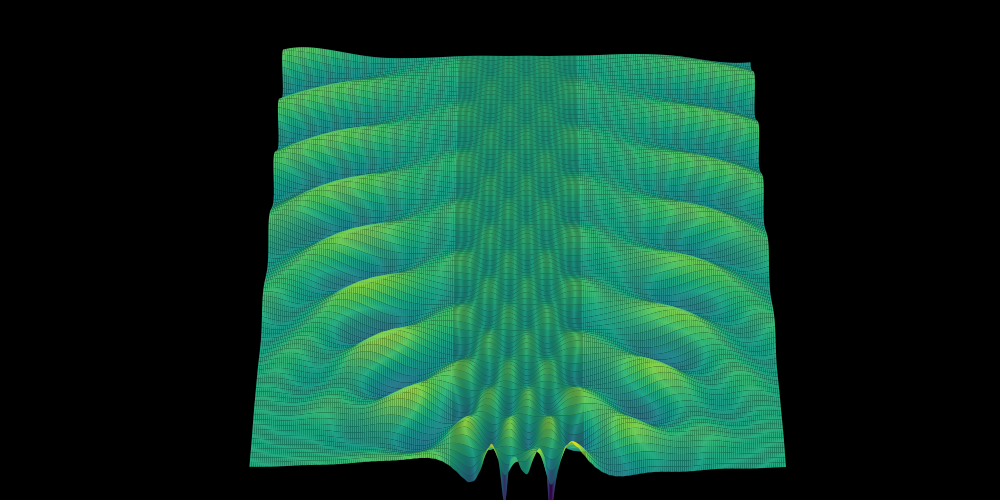

In [116]:
A.plot_field_2d_surface(Rad, zmax=8, rstride=1, cstride=1)

(<Figure size 1000x500 with 1 Axes>, <Axes3D: >)

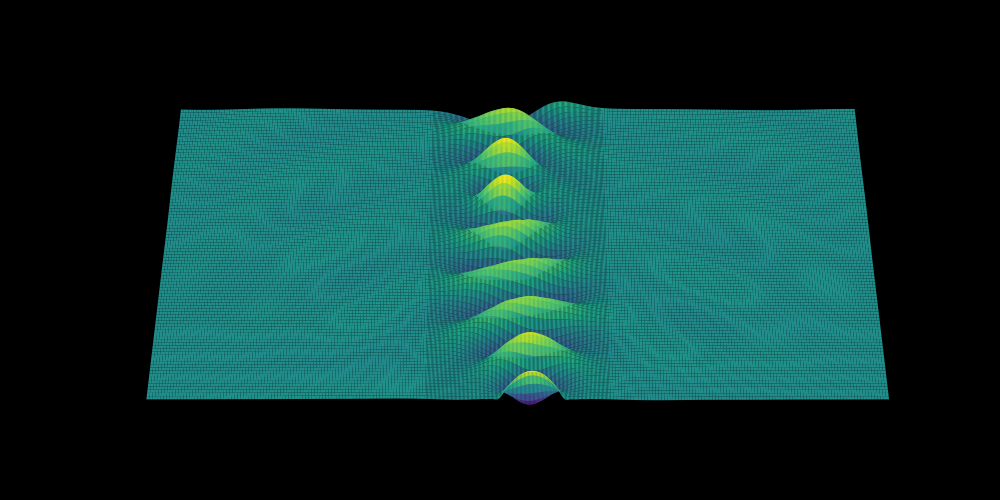

In [115]:
A.plot_field_2d_surface(Full, zmax=4, rstride=1, cstride=1)